---
title: Design and Impact of Automated Decision Systems
author: Evan Flaks
date: '2025-03-05'
image: "loan.jpeg"
description: "Building and analyzing an automated system for a bank extending credit"
format: html
---

# Abstract

In this project, I developed a machine learning-based loan approval system designed to predict the likelihood of loan default and optimize lending decisions for a financial institution. Using a dataset containing borrower information such as age, income, employment length, homeownership status, and credit history, I first created data visualizations and summary tables to explore trends in the data. Then, I implemented a logistic regression model to classify applicants as either high-risk (default) or low-risk (non-default) and create a score function with a weight vector to weight each feature into the decision process. Then, to decide on a threshold value for my score function, I conducted a profit optimization analysis, adjusting approval thresholds to maximize expected returns. Through this study, I evaluated how loan approval rates varied across age groups, income levels, and loan purposes, ultimately assessing the fairness and efficiency of an automated credit decision system.

# Data Extraction

We begin by downloading the data from the source. The columns in this data include extensive information about the prospective borrower -- age, income, home owndership, loan intent, etc. 

In [1]:
import pandas as pd
url = "https://raw.githubusercontent.com/PhilChodrow/ml-notes/main/data/credit-risk/train.csv"
df_train = pd.read_csv(url)
df_train.head()


,person_age,person_income,person_home_ownership,person_emp_length,loan_intent,loan_grade,loan_amnt,loan_int_rate,loan_status,loan_percent_income,cb_person_default_on_file,cb_person_cred_hist_length
0,25,43200,RENT,NaN,VENTURE,B,1200,9.91,0,0.03,N,4
1,27,98000,RENT,3.0,EDUCATION,C,11750,13.47,0,0.12,Y,6
2,22,36996,RENT,5.0,EDUCATION,A,10000,7.51,0,0.27,N,4
3,24,26000,RENT,2.0,MEDICAL,C,1325,12.87,1,0.05,N,4
4,29,53004,MORTGAGE,2.0,HOMEIMPROVEMENT,A,15000,9.63,0,0.28,N,10


# Data Exploration

Now I will create some visualizations to explore patterns in the data.

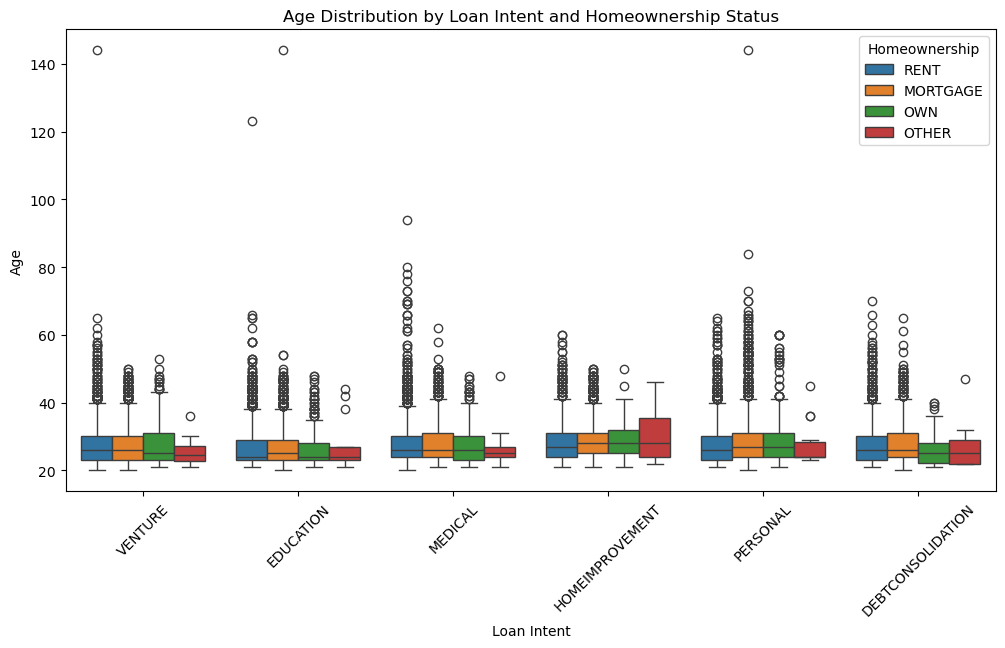

In [2]:
import matplotlib.pyplot as plt
import seaborn as sns

plt.figure(figsize=(12, 6))
sns.boxplot(x='loan_intent', y='person_age', hue='person_home_ownership', data=df_train)
plt.title("Age Distribution by Loan Intent and Homeownership Status")
plt.xlabel("Loan Intent")
plt.ylabel("Age")
plt.xticks(rotation=45)
plt.legend(title="Homeownership")

This boxplot helps visualize the distribution of borrowers' ages across different loan intents, while also distinguishing between different homeownership statuses. An immediate observation that I have is that the interquartile range for every loan type and homeownership status falls around 20-30 years of age, meaning that is the main age group seeking all types of loans. Another notable observation is the outliers per category. There are a lot more y-axis outliers (i.e. older people) that rent their homes, meaning it is common for older renters to be seeking a loan in almost all loan categories as opposed to older homeowners or mortgagers. Further, the largest age outlier category falls in the blue medical section of the x-axis, meaning that older-age renters are often seeking medical loans. 

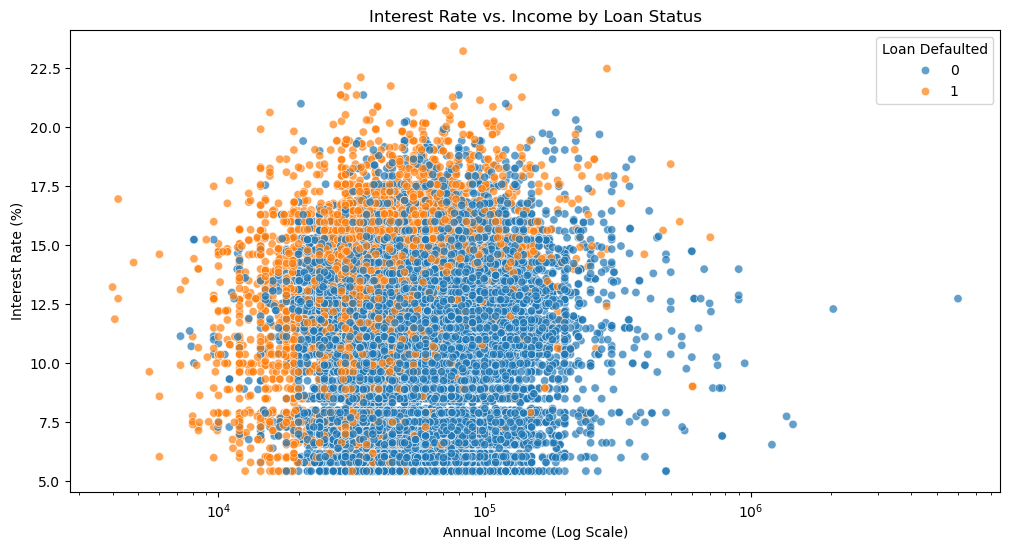

In [3]:
plt.figure(figsize=(12, 6))
sns.scatterplot(x='person_income', y='loan_int_rate', hue='loan_status', data=df_train, alpha=0.7)
plt.xscale("log")  # Log scale to handle wide income range
plt.title("Interest Rate vs. Income by Loan Status")
plt.xlabel("Annual Income (Log Scale)")
plt.ylabel("Interest Rate (%)")
plt.legend(title="Loan Defaulted")
plt.show()

This scatter plot helps us visualize the relationship between a person's income and the interest rate they are offered, and whether or not that loan was defaulted. As we can see by the scattering, there is no clear relationship between income and interest rate; there are both high income people with low and high interest rates, and there are low income people with both high and low interest rates. However, the abundance of orange to the top and left of the plot tells us that those with lower annual incomes tend to default on their loans much more often as opposed to higher-income individuals. 

In [4]:
summary_table = df_train.groupby('person_emp_length').agg({
    'loan_amnt': 'mean',
    'loan_int_rate': 'mean',
    'loan_percent_income': 'mean'
}).reset_index()

# Rename columns for clarity
summary_table.columns = ['Employment Length (Years)', 'Avg Loan Amount', 'Avg Interest Rate (%)', 'Avg Loan as % of Income']

# Display the summary table
display(summary_table)

,Employment Length (Years),Avg Loan Amount,Avg Interest Rate (%),Avg Loan as % of Income
0,0.0,8572.957492,11.212005,0.174275
1,1.0,9196.537307,11.356443,0.178396
2,2.0,9142.199217,11.302131,0.174799
3,3.0,9448.739572,11.095799,0.170120
4,4.0,9392.330416,11.215608,0.169326
5,5.0,9596.843434,10.857377,0.171835
6,6.0,9735.197368,10.775047,0.172580
7,7.0,10095.776060,10.930345,0.163076
8,8.0,10439.578714,10.577886,0.162084
9,9.0,10799.319419,10.904209,0.160971


From this summary table, we can see that typically those who have been employed longer get access to larger lines of credit. While the correlation is not super strong, it can be said that those who have been employed a short time (0-6) years are much more likely to get a loan that is worth less than $10,000.

# Building a Model to Find a Weight Vector

Below, I have trained a logistic regression model to predict whether a borrower will default on a loan based on all of the given features in the data set aside from loan grade and loan status (the target variable). I first separate the features into numeric (e.g., income, loan amount) and categorical (e.g., homeownership, loan intent). The numeric features are standardized using StandardScaler, while categorical features are one-hot encoded using OneHotEncoder, all managed through a ColumnTransformer. A Pipeline is then created to preprocess the data and train a logistic regression model. Finally, the weight vector (model coefficients) is retrieved, and cross-validation is performed to assess the model’s accuracy across five folds. The accuracy scores and mean accuracy are printed to evaluate the model’s predictive performance.

In [6]:
import pandas as pd
import numpy as np
from sklearn.preprocessing import StandardScaler, OneHotEncoder
from sklearn.linear_model import LogisticRegression
from sklearn.pipeline import Pipeline
from sklearn.compose import ColumnTransformer
from sklearn.model_selection import cross_val_score



# List of features (excluding forbidden ones)
features = [
    "person_age", "person_income", "person_home_ownership", "person_emp_length",
    "loan_intent", "loan_amnt", "loan_int_rate", "loan_percent_income",
    "cb_person_default_on_file", "cb_person_cred_hist_length"
]

# Target variable
target = "loan_status"

# Example placeholder for DataFrame

# Splitting numeric and categorical features
numeric_features = ["person_age", "person_income", "person_emp_length", "loan_amnt", "loan_int_rate", "loan_percent_income", "cb_person_cred_hist_length"]
categorical_features = ["person_home_ownership", "loan_intent", "cb_person_default_on_file"]

# Preprocessing
numeric_transformer = StandardScaler()
categorical_transformer = OneHotEncoder(handle_unknown='ignore')

preprocessor = ColumnTransformer(
    transformers=[
        ('num', numeric_transformer, numeric_features),
        ('cat', categorical_transformer, categorical_features)
    ]
)
df = df_train.dropna()
# Define logistic regression model
model = Pipeline([
    ('preprocessor', preprocessor),
    ('classifier', LogisticRegression(max_iter=1000, random_state=42))
])

# Prepare data
X = df[features]
y = df[target]

# Ensure target variable is binary (1 = Default, 0 = Non-Default)
y = y.map({'Default': 1, 'Non-Default': 0}) if y.dtype == 'object' else y

# Fit the model
model.fit(X, y)

# Retrieve the weight vector
weights = model.named_steps['classifier'].coef_
print("Weight vector (w):", weights)

# Cross-validation to evaluate model accuracy
cv_scores = cross_val_score(model, X, y, cv=5, scoring='accuracy')
print("Cross-validation accuracy scores:", cv_scores)
print("Mean accuracy:", np.mean(cv_scores))


Weight vector (w): [[-0.0383707   0.04510115 -0.02445074 -0.58076891  1.03715014  1.3244998
  -0.01195797  0.12828473  0.37763254 -1.36247275  0.86221669  0.42979327
  -0.37518745  0.50616243  0.24713985 -0.19722704 -0.60501984 -0.0351749
   0.04083611]]
Cross-validation accuracy scores: [0.85268442 0.85421213 0.84566688 0.84654006 0.84981445]
Mean accuracy: 0.8497835888866307


From this we can see that our weight vector for all of the features is 
w = [-0.0383707   0.04510115 -0.02445074 -0.58076891  1.03715014  1.3244998
  -0.01195797  0.12828473  0.37763254 -1.36247275  0.86221669  0.42979327
  -0.37518745  0.50616243  0.24713985 -0.19722704 -0.60501984 -0.0351749
   0.04083611]

And our mean accuracy across our cross-validations is 0.849, meaning we predicted around 85% of loan approval decisions to be correct (did not default).

# Finding a Threshold

Now we must find a threshold. To do this, the code below first generates predicted probabilities of loan default from the logistic regression model and defines a range of threshold values between 0 and 1. The profit if a loan is repaid and the loss if a loan defaults are computed using the following assumptions:

1. If ‍‍‍‍‍‍‍‍‍‍‍‍‍‍‍‍‍‍‍‍the ‍‍‍‍‍‍‍‍‍‍‍‍‍‍‍‍‍‍‍‍loan ‍‍‍‍‍‍‍‍‍‍‍‍‍‍‍‍‍‍‍‍is ‍‍‍‍‍‍‍‍‍‍‍‍‍‍‍‍‍‍‍‍repaid ‍‍‍‍‍‍‍‍‍‍‍‍‍‍‍‍‍‍‍‍in ‍‍‍‍‍‍‍‍‍‍‍‍‍‍‍‍‍‍‍‍full, ‍‍‍‍‍‍‍‍‍‍‍‍‍‍‍‍‍‍‍‍the ‍‍‍‍‍‍‍‍‍‍‍‍‍‍‍‍‍‍‍‍profit ‍‍‍‍‍‍‍‍‍‍‍‍‍‍‍‍‍‍‍‍for ‍‍‍‍‍‍‍‍‍‍‍‍‍‍‍‍‍‍‍‍the ‍‍‍‍‍‍‍‍‍‍‍‍‍‍‍‍‍‍‍‍bank ‍‍‍‍‍‍‍‍‍‍‍‍‍‍‍‍‍‍‍‍is ‍‍‍‍‍‍‍‍‍‍‍‍‍‍‍‍‍‍‍‍equal ‍‍‍‍‍‍‍‍‍‍‍‍‍‍‍‍‍‍‍‍to ‍‍‍‍‍‍‍‍‍‍‍‍‍‍‍‍‍‍‍‍loan_amnt*(1 + 0.25*loan_int_rate)**10 - loan_amnt. ‍‍‍‍‍‍‍‍‍‍‍‍‍‍‍‍‍‍‍‍This ‍‍‍‍‍‍‍‍‍‍‍‍‍‍‍‍‍‍‍‍formula ‍‍‍‍‍‍‍‍‍‍‍‍‍‍‍‍‍‍‍‍assumes ‍‍‍‍‍‍‍‍‍‍‍‍‍‍‍‍‍‍‍‍that ‍‍‍‍‍‍‍‍‍‍‍‍‍‍‍‍‍‍‍‍the ‍‍‍‍‍‍‍‍‍‍‍‍‍‍‍‍‍‍‍‍profit ‍‍‍‍‍‍‍‍‍‍‍‍‍‍‍‍‍‍‍‍earned ‍‍‍‍‍‍‍‍‍‍‍‍‍‍‍‍‍‍‍‍by ‍‍‍‍‍‍‍‍‍‍‍‍‍‍‍‍‍‍‍‍the ‍‍‍‍‍‍‍‍‍‍‍‍‍‍‍‍‍‍‍‍bank ‍‍‍‍‍‍‍‍‍‍‍‍‍‍‍‍‍‍‍‍on ‍‍‍‍‍‍‍‍‍‍‍‍‍‍‍‍‍‍‍‍a ‍‍‍‍‍‍‍‍‍‍‍‍‍‍‍‍‍‍‍‍10-year ‍‍‍‍‍‍‍‍‍‍‍‍‍‍‍‍‍‍‍‍loan ‍‍‍‍‍‍‍‍‍‍‍‍‍‍‍‍‍‍‍‍is ‍‍‍‍‍‍‍‍‍‍‍‍‍‍‍‍‍‍‍‍equal ‍‍‍‍‍‍‍‍‍‍‍‍‍‍‍‍‍‍‍‍to ‍‍‍‍‍‍‍‍‍‍‍‍‍‍‍‍‍‍‍‍25% ‍‍‍‍‍‍‍‍‍‍‍‍‍‍‍‍‍‍‍‍of ‍‍‍‍‍‍‍‍‍‍‍‍‍‍‍‍‍‍‍‍the ‍‍‍‍‍‍‍‍‍‍‍‍‍‍‍‍‍‍‍‍interest ‍‍‍‍‍‍‍‍‍‍‍‍‍‍‍‍‍‍‍‍rate ‍‍‍‍‍‍‍‍‍‍‍‍‍‍‍‍‍‍‍‍each ‍‍‍‍‍‍‍‍‍‍‍‍‍‍‍‍‍‍‍‍year, ‍‍‍‍‍‍‍‍‍‍‍‍‍‍‍‍‍‍‍‍with ‍‍‍‍‍‍‍‍‍‍‍‍‍‍‍‍‍‍‍‍the ‍‍‍‍‍‍‍‍‍‍‍‍‍‍‍‍‍‍‍‍other ‍‍‍‍‍‍‍‍‍‍‍‍‍‍‍‍‍‍‍‍75% ‍‍‍‍‍‍‍‍‍‍‍‍‍‍‍‍‍‍‍‍of ‍‍‍‍‍‍‍‍‍‍‍‍‍‍‍‍‍‍‍‍the ‍‍‍‍‍‍‍‍‍‍‍‍‍‍‍‍‍‍‍‍interest ‍‍‍‍‍‍‍‍‍‍‍‍‍‍‍‍‍‍‍‍going ‍‍‍‍‍‍‍‍‍‍‍‍‍‍‍‍‍‍‍‍to ‍‍‍‍‍‍‍‍‍‍‍‍‍‍‍‍‍‍‍‍things ‍‍‍‍‍‍‍‍‍‍‍‍‍‍‍‍‍‍‍‍like ‍‍‍‍‍‍‍‍‍‍‍‍‍‍‍‍‍‍‍‍salaries ‍‍‍‍‍‍‍‍‍‍‍‍‍‍‍‍‍‍‍‍for ‍‍‍‍‍‍‍‍‍‍‍‍‍‍‍‍‍‍‍‍the ‍‍‍‍‍‍‍‍‍‍‍‍‍‍‍‍‍‍‍‍people ‍‍‍‍‍‍‍‍‍‍‍‍‍‍‍‍‍‍‍‍who ‍‍‍‍‍‍‍‍‍‍‍‍‍‍‍‍‍‍‍‍manage ‍‍‍‍‍‍‍‍‍‍‍‍‍‍‍‍‍‍‍‍the ‍‍‍‍‍‍‍‍‍‍‍‍‍‍‍‍‍‍‍‍bank. ‍‍‍‍‍‍‍‍‍‍‍‍‍‍‍‍‍‍‍‍It ‍‍‍‍‍‍‍‍‍‍‍‍‍‍‍‍‍‍‍‍is ‍‍‍‍‍‍‍‍‍‍‍‍‍‍‍‍‍‍‍‍extremely ‍‍‍‍‍‍‍‍‍‍‍‍‍‍‍‍‍‍‍‍simplistic ‍‍‍‍‍‍‍‍‍‍‍‍‍‍‍‍‍‍‍‍and ‍‍‍‍‍‍‍‍‍‍‍‍‍‍‍‍‍‍‍‍does ‍‍‍‍‍‍‍‍‍‍‍‍‍‍‍‍‍‍‍‍not ‍‍‍‍‍‍‍‍‍‍‍‍‍‍‍‍‍‍‍‍account ‍‍‍‍‍‍‍‍‍‍‍‍‍‍‍‍‍‍‍‍for ‍‍‍‍‍‍‍‍‍‍‍‍‍‍‍‍‍‍‍‍inflation, ‍‍‍‍‍‍‍‍‍‍‍‍‍‍‍‍‍‍‍‍amortization ‍‍‍‍‍‍‍‍‍‍‍‍‍‍‍‍‍‍‍‍over ‍‍‍‍‍‍‍‍‍‍‍‍‍‍‍‍‍‍‍‍time, ‍‍‍‍‍‍‍‍‍‍‍‍‍‍‍‍‍‍‍‍opportunity ‍‍‍‍‍‍‍‍‍‍‍‍‍‍‍‍‍‍‍‍costs, ‍‍‍‍‍‍‍‍‍‍‍‍‍‍‍‍‍‍‍‍etc.

2. If ‍‍‍‍‍‍‍‍‍‍‍‍‍‍‍‍‍‍‍‍the ‍‍‍‍‍‍‍‍‍‍‍‍‍‍‍‍‍‍‍‍borrower ‍‍‍‍‍‍‍‍‍‍‍‍‍‍‍‍‍‍‍‍defaults ‍‍‍‍‍‍‍‍‍‍‍‍‍‍‍‍‍‍‍‍on ‍‍‍‍‍‍‍‍‍‍‍‍‍‍‍‍‍‍‍‍the ‍‍‍‍‍‍‍‍‍‍‍‍‍‍‍‍‍‍‍‍loan, ‍‍‍‍‍‍‍‍‍‍‍‍‍‍‍‍‍‍‍‍the ‍‍‍‍‍‍‍‍‍‍‍‍‍‍‍‍‍‍‍‍“profit” ‍‍‍‍‍‍‍‍‍‍‍‍‍‍‍‍‍‍‍‍for ‍‍‍‍‍‍‍‍‍‍‍‍‍‍‍‍‍‍‍‍the ‍‍‍‍‍‍‍‍‍‍‍‍‍‍‍‍‍‍‍‍bank ‍‍‍‍‍‍‍‍‍‍‍‍‍‍‍‍‍‍‍‍is ‍‍‍‍‍‍‍‍‍‍‍‍‍‍‍‍‍‍‍‍equal ‍‍‍‍‍‍‍‍‍‍‍‍‍‍‍‍‍‍‍‍to ‍‍‍‍‍‍‍‍‍‍‍‍‍‍‍‍‍‍‍‍loan_amnt*(1 + 0.25*loan_int_rate)**3 - 1.7*loan_amnt. ‍‍‍‍‍‍‍‍‍‍‍‍‍‍‍‍‍‍‍‍This ‍‍‍‍‍‍‍‍‍‍‍‍‍‍‍‍‍‍‍‍formula ‍‍‍‍‍‍‍‍‍‍‍‍‍‍‍‍‍‍‍‍corresponds ‍‍‍‍‍‍‍‍‍‍‍‍‍‍‍‍‍‍‍‍to ‍‍‍‍‍‍‍‍‍‍‍‍‍‍‍‍‍‍‍‍the ‍‍‍‍‍‍‍‍‍‍‍‍‍‍‍‍‍‍‍‍same ‍‍‍‍‍‍‍‍‍‍‍‍‍‍‍‍‍‍‍‍profit-earning ‍‍‍‍‍‍‍‍‍‍‍‍‍‍‍‍‍‍‍‍mechanism ‍‍‍‍‍‍‍‍‍‍‍‍‍‍‍‍‍‍‍‍as ‍‍‍‍‍‍‍‍‍‍‍‍‍‍‍‍‍‍‍‍above, ‍‍‍‍‍‍‍‍‍‍‍‍‍‍‍‍‍‍‍‍but ‍‍‍‍‍‍‍‍‍‍‍‍‍‍‍‍‍‍‍‍assumes ‍‍‍‍‍‍‍‍‍‍‍‍‍‍‍‍‍‍‍‍that ‍‍‍‍‍‍‍‍‍‍‍‍‍‍‍‍‍‍‍‍the ‍‍‍‍‍‍‍‍‍‍‍‍‍‍‍‍‍‍‍‍borrower ‍‍‍‍‍‍‍‍‍‍‍‍‍‍‍‍‍‍‍‍defaults ‍‍‍‍‍‍‍‍‍‍‍‍‍‍‍‍‍‍‍‍three ‍‍‍‍‍‍‍‍‍‍‍‍‍‍‍‍‍‍‍‍years ‍‍‍‍‍‍‍‍‍‍‍‍‍‍‍‍‍‍‍‍into ‍‍‍‍‍‍‍‍‍‍‍‍‍‍‍‍‍‍‍‍the ‍‍‍‍‍‍‍‍‍‍‍‍‍‍‍‍‍‍‍‍loan ‍‍‍‍‍‍‍‍‍‍‍‍‍‍‍‍‍‍‍‍and ‍‍‍‍‍‍‍‍‍‍‍‍‍‍‍‍‍‍‍‍that ‍‍‍‍‍‍‍‍‍‍‍‍‍‍‍‍‍‍‍‍the ‍‍‍‍‍‍‍‍‍‍‍‍‍‍‍‍‍‍‍‍bank ‍‍‍‍‍‍‍‍‍‍‍‍‍‍‍‍‍‍‍‍loses ‍‍‍‍‍‍‍‍‍‍‍‍‍‍‍‍‍‍‍‍70% ‍‍‍‍‍‍‍‍‍‍‍‍‍‍‍‍‍‍‍‍of ‍‍‍‍‍‍‍‍‍‍‍‍‍‍‍‍‍‍‍‍the ‍‍‍‍‍‍‍‍‍‍‍‍‍‍‍‍‍‍‍‍principal.

For each threshold, the model classifies loan applicants, determining whether they are approved or denied. The total expected profit is then computed by summing profits from repaid loans and losses from defaulted loans. The optimal threshold is selected as the one that yields the highest total profit.

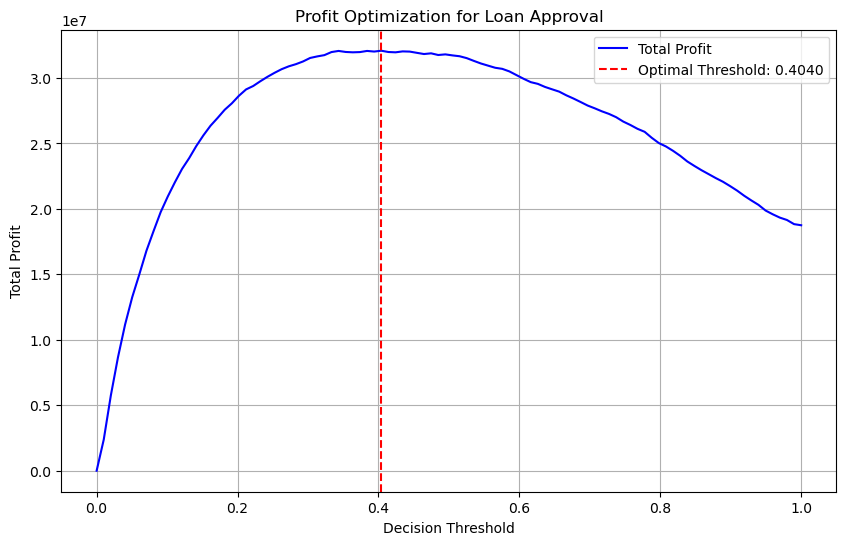

Optimal Threshold: 0.4040
Maximum Profit: 32086998.37
Expected Profit per Borrower: 1400.75


In [7]:
import numpy as np
import matplotlib.pyplot as plt

# Generate predicted probabilities from the logistic regression model
y_prob = model.predict_proba(X)[:, 1]

# Define a range of threshold values to test
thresholds = np.linspace(0, 1, 100)

# Extract loan amounts and interest rates as numpy arrays
loan_amounts = X["loan_amnt"].to_numpy()
interest_rates = X["loan_int_rate"].to_numpy()

# Ensure interest rates are correctly scaled (divided by 100 if necessary)
if interest_rates.max() > 1:  # If the max value is greater than 1, assume percentages need scaling
    interest_rates /= 100

# Compute profit if loan is repaid and loss if defaulted (vectorized)
profit_if_repaid = loan_amounts * ((1 + 0.25 * interest_rates) ** 10) - loan_amounts
loss_if_defaulted = loan_amounts * ((1 + 0.25 * interest_rates) ** 3) - (1.7 * loan_amounts)

# Ensure y is a NumPy array
y_np = y.to_numpy()

# Vectorized computation of profit for each threshold
profits = np.zeros_like(thresholds)

for i, t in enumerate(thresholds):
    predictions = (y_prob >= t).astype(int)  # Convert probabilities to binary predictions
    approved_loans = predictions == 0  # Loans that are approved

    # Compute total profit
    total_profit = np.sum(profit_if_repaid[(y_np == 0) & approved_loans]) + np.sum(loss_if_defaulted[(y_np == 1) & approved_loans])
    profits[i] = total_profit

# Find the threshold that maximizes profit
optimal_threshold = thresholds[np.argmax(profits)]
max_profit = profits.max()
expected_profit_per_borrower = max_profit / len(y_prob)

# Plot the profit curve
plt.figure(figsize=(10, 6))
plt.plot(thresholds, profits, label="Total Profit", color='blue')
plt.axvline(optimal_threshold, color='red', linestyle="--", label=f"Optimal Threshold: {optimal_threshold:.4f}")
plt.xlabel("Decision Threshold")
plt.ylabel("Total Profit")
plt.title("Profit Optimization for Loan Approval")
plt.legend()
plt.grid(True)
plt.show()

# Output the results
print(f"Optimal Threshold: {optimal_threshold:.4f}")
print(f"Maximum Profit: {max_profit:.2f}")
print(f"Expected Profit per Borrower: {expected_profit_per_borrower:.2f}")


Above, I have plotted a profit curve to visualize how profit changes with different decision thresholds, with the optimal threshold marked in red. As we can see, the threshold that optimizes profits is t = 0.4040, generating $1400.75 in profit per borrower.

# Model Evaluation: Bank's Perspective

Now that I have finalized our weight vector **w** and threshold *t*, I am going to evaluate the performance of the logistic regression model on the test dataset. The code below loads and cleans the test data by dropping missing values, extracts relevant features, and the target variable (loan_status) is mapped to binary values.


Under the financial formula assumptions provided above, the optimal threshold of t =  0.4040 is applied to classify loans as approved (0) or denied (1). The total profit is computed by summing profits from repaid loans and losses from defaulted loans within the approved subset. Finally, the expected profit per borrower is derived by dividing total profit by the number of test borrowers.

In [49]:
url = "https://raw.githubusercontent.com/PhilChodrow/ml-notes/main/data/credit-risk/test.csv"
df_test_dirty = pd.read_csv(url)
df_test = df_test_dirty.dropna()

import pandas as pd
import numpy as np

# Extract relevant features from the test set (excluding forbidden ones)
X_test = df_test[["person_age", "person_income", "person_home_ownership", "person_emp_length",
                  "loan_intent", "loan_amnt", "loan_int_rate", "loan_percent_income",
                  "cb_person_default_on_file", "cb_person_cred_hist_length"]]

# Extract true labels
y_test = df_test["loan_status"]

# Ensure target variable is binary (1 = Default, 0 = Non-Default)
y_test = y_test.map({'Default': 1, 'Non-Default': 0}) if y_test.dtype == 'object' else y_test

# Get predicted probabilities for the positive class (default) using trained model
y_prob_test = model.predict_proba(X_test)[:, 1]

# Extract loan amounts and interest rates as numpy arrays
loan_amounts_test = X_test["loan_amnt"].to_numpy()
interest_rates_test = X_test["loan_int_rate"].to_numpy()

# Ensure interest rates are correctly scaled (divided by 100 if necessary)
if interest_rates_test.max() > 1:  # If the max value is greater than 1, assume percentages need scaling
    interest_rates_test /= 100

# Compute profit if loan is repaid and loss if defaulted (vectorized)
profit_if_repaid_test = loan_amounts_test * ((1 + 0.25 * interest_rates_test) ** 10) - loan_amounts_test
loss_if_defaulted_test = loan_amounts_test * ((1 + 0.25 * interest_rates_test) ** 3) - (1.7 * loan_amounts_test)

# Ensure y_test is a NumPy array
y_test_np = y_test.to_numpy()

# Apply the chosen threshold to make loan approval decisions
predictions_test = (y_prob_test >= optimal_threshold).astype(int)
approved_loans_test = predictions_test == 0  # Loans that are approved

# Compute total profit on the test set
total_profit_test = np.sum(profit_if_repaid_test[(y_test_np == 0) & approved_loans_test]) + \
                    np.sum(loss_if_defaulted_test[(y_test_np == 1) & approved_loans_test])

# Compute expected profit per borrower
expected_profit_per_borrower_test = total_profit_test / len(y_test_np)

print(f"Total Profit on Test Set: {total_profit_test:.2f}")
print(f"Expected Profit per Borrower on Test Set: {expected_profit_per_borrower_test:.2f}")


Total Profit on Test Set: 7684515.98
Expected Profit per Borrower on Test Set: 1340.87


As we can see, the expected profit per borrower on the test set is $1340.87, which is very similar to the value of $1400.75 that was calculated on the training set. From a Bank's perspective, our model is reasonably profitable and accurate.

# Model Evaluation: Borrower's Perspective

Now we will evaluate our model from the borrower's perspective. This code analyzes the loan approval rates under the model’s decision system across different demographic and financial groups. The analysis is divided into three key perspectives:

Age Groups: Borrowers are categorized into age brackets, and approval rates are computed for each group.

Loan Type (Medical vs. Other): Loans are grouped into Medical and Other categories, and their respective approval and default rates are calculated.

Income Levels: Borrowers are divided into five quintile income brackets, and approval rates for each group are determined. 

In [55]:
import pandas as pd
import numpy as np

# Create a copy to avoid modifying the original DataFrame
df_test = df_test.copy()

# Assign approval results safely
df_test.loc[:, "approved"] = approved_loans_test

# Analyze approval rates across age groups
age_groups = pd.cut(df_test["person_age"], bins=[18, 25, 35, 50, 65, 100], labels=["18-24", "25-34", "35-49", "50-64", "65+"])
approval_rate_by_age = df_test.groupby(age_groups)["approved"].mean()

# Create a new column to categorize loans as 'Medical' or 'Other'
df_test.loc[:, "loan_category"] = df_test["loan_intent"].apply(lambda x: "Medical" if x == "MEDICAL" else "Other")

# Compute approval rates
approval_rate_medical = df_test[df_test["loan_category"] == "Medical"]["approved"].mean()
approval_rate_other = df_test[df_test["loan_category"] == "Other"]["approved"].mean()

# Compute default rates
default_rate_medical = df_test[df_test["loan_category"] == "Medical"]["loan_status"].mean()
default_rate_other = df_test[df_test["loan_category"] == "Other"]["loan_status"].mean()

# Analyze impact of income on loan approvals
income_groups = pd.qcut(df_test["person_income"], q=5, labels=["Low", "Lower-Middle", "Middle", "Upper-Middle", "High"])
approval_rate_by_income = df_test.groupby(income_groups)["approved"].mean()

# Display results
print("Loan Approval Rates by Age Group:")
print(approval_rate_by_age)

print("\nLoan Approval and Default Rates by Loan Type:")
print(f"Medical - Approval Rate: {approval_rate_medical:.2f}, Default Rate: {default_rate_medical:.2f}")
print(f"Other - Approval Rate: {approval_rate_other:.2f}, Default Rate: {default_rate_other:.2f}")

print("\nLoan Approval Rates by Income Group:")
print(approval_rate_by_income)


Loan Approval Rates by Age Group:
person_age
18-24    0.779661
25-34    0.815186
35-49    0.848432
50-64    0.731707
65+      1.000000
Name: approved, dtype: float64

Loan Approval and Default Rates by Loan Type:

Loan Approval and Default Rates for Medical vs. Other Loans:
Medical - Approval Rate: 0.74, Default Rate: 0.28
Other - Approval Rate: 0.82, Default Rate: 0.21

Loan Approval Rates by Income Group:
person_income
Low             0.575152
Lower-Middle    0.723222
Middle          0.835861
Upper-Middle    0.901482
High            0.973799
Name: approved, dtype: float64


From the first table we can see that my model predicts that the group with the lowest loan approval rates is 50-64. Aside from that group, the younger age groups tend to have lower approval ratings. This means, according to my model, it is most difficult for people aged 50-64 to get loans. Whereas people above the age of 65 are guaranteed to be approved.

From the second table we can see that my model predicts medical loans have a lower approval rating and a higher default rate when compared to other loans. So, according to my model, it is more difficult for people to get loans for medical expenses than it is for business, education, homes, etc., but it is also more common for people to default on medical loans.

From the third table, we can see that my model predicts the loan approval rate to be worse for lower income individuals, and as someone moves into a higher income group, they have a higher chance of loan approval. Thus, it is much easer for a wealthier person to get access to credit under my system.

# Reflection

Thoughout this project, I learned a lot about automated decision systems. While the model was designed to maximize lender profitability and reduce financial risk, these systems have far-reaching consequences beyond financial efficiency. Decisions made by models like mine directly impact people’s access to credit—a critical resource for economic mobility, education, healthcare, and entrepreneurship. By relying on historical data and statistical relationships, machine learning models can often reinforce existing inequalities in financial systems. For example, my study revealed that younger applicants and lower-income individuals had lower approval rates, reflecting biases where those already struggling financially find it even harder to secure credit. It is not feasible for banks to give out loans to people who are likely to default on them, and machine learning models can very accurately predict whether someone is high or low risk. However, these models are rarely 100% accurate (mine was 85%). For someone in a high-risk group that will be able to pay back a loan but never gets accepted, this decision-making system seems unfair and negatively impacts people from these high-risk groups.

Another controversy arises when discussing medical loans. Applicants seeking loans for medical expenses faced higher rejection rates due to their higher historical default rates. Considering ‍‍‍‍‍‍‍‍‍‍‍‍‍‍‍‍‍‍‍‍that ‍‍‍‍‍‍‍‍‍‍‍‍‍‍‍‍‍‍‍‍people ‍‍‍‍‍‍‍‍‍‍‍‍‍‍‍‍‍‍‍‍seeking ‍‍‍‍‍‍‍‍‍‍‍‍‍‍‍‍‍‍‍‍loans ‍‍‍‍‍‍‍‍‍‍‍‍‍‍‍‍‍‍‍‍for ‍‍‍‍‍‍‍‍‍‍‍‍‍‍‍‍‍‍‍‍medical ‍‍‍‍‍‍‍‍‍‍‍‍‍‍‍‍‍‍‍‍expense ‍‍‍‍‍‍‍‍‍‍‍‍‍‍‍‍‍‍‍‍have ‍‍‍‍‍‍‍‍‍‍‍‍‍‍‍‍‍‍‍‍high ‍‍‍‍‍‍‍‍‍‍‍‍‍‍‍‍‍‍‍‍rates ‍‍‍‍‍‍‍‍‍‍‍‍‍‍‍‍‍‍‍‍of ‍‍‍‍‍‍‍‍‍‍‍‍‍‍‍‍‍‍‍‍default, ‍‍‍‍‍‍‍‍‍‍‍‍‍‍‍‍‍‍‍‍is ‍‍‍‍‍‍‍‍‍‍‍‍‍‍‍‍‍‍‍‍it ‍‍‍‍‍‍‍‍‍‍‍‍‍‍‍‍‍‍‍‍fair ‍‍‍‍‍‍‍‍‍‍‍‍‍‍‍‍‍‍‍‍that ‍‍‍‍‍‍‍‍‍‍‍‍‍‍‍‍‍‍‍‍it ‍‍‍‍‍‍‍‍‍‍‍‍‍‍‍‍‍‍‍‍is ‍‍‍‍‍‍‍‍‍‍‍‍‍‍‍‍‍‍‍‍more ‍‍‍‍‍‍‍‍‍‍‍‍‍‍‍‍‍‍‍‍difficult ‍‍‍‍‍‍‍‍‍‍‍‍‍‍‍‍‍‍‍‍for ‍‍‍‍‍‍‍‍‍‍‍‍‍‍‍‍‍‍‍‍them ‍‍‍‍‍‍‍‍‍‍‍‍‍‍‍‍‍‍‍‍to ‍‍‍‍‍‍‍‍‍‍‍‍‍‍‍‍‍‍‍‍obtain ‍‍‍‍‍‍‍‍‍‍‍‍‍‍‍‍‍‍‍‍access ‍‍‍‍‍‍‍‍‍‍‍‍‍‍‍‍‍‍‍‍to ‍‍‍‍‍‍‍‍‍‍‍‍‍‍‍‍‍‍‍‍credit? In the context of credit, I would define a fair system as one that uses objective and relevant financial factors without discrimination on vulnerable groups. However, sick people are often vulnerable as they often cannot work and have no control over their financial situation. This highlights the flaws in purely data-driven credit decisions. While lenders must manage risk, rejecting medical borrowers based solely on historical default rates ignores the uncontrollable nature of medical crises. True fairness should account for context, distinguishing between defaults caused by financial irresponsibility and those driven by hardship. A more ethical system would incorporate alternative lending structures—such as flexible repayment plans or government-backed medical loans—to ensure vulnerable borrowers aren’t automatically excluded from financial support. The challenge is not just predicting risk, but balancing objective financial metrics with contextual and individual nuance in credit decisions.